様々な言語の Spell と Sound (IPA) の構造を LDA で探索する
黒田　航　(kow.kuroda@gmail.com)

2024/03/26 i. FastText のエンコードを追加; ii. UMAP を使った次元圧縮を追加; iii. DSBSCANクラスターに帰属する個数の相関をHeatmap にする処理を追加

In [2286]:
## imports
import sys, os, random, re, glob
import pandas as pd
import pprint as pp
#from functools import reduce

設定

In [2287]:
## 処理設定
verbose = False

## 全言語をカバーできる色パレットの用意
import plotly
color_palette = plotly.colors.qualitative.Dark24

In [2288]:
### LDA 用 (FastText と併用可能)
use_LDA = True

## トピック数
n_topics      = 10 # 30は多過ぎる？

### DTM 構築: doc, term の設定
## doc
doc_type      = 'form'  # 変更不可
doc_attrs     = [ 'spell', 'sound' ]
doc_attr      = doc_attrs[0]
print(f"doc_attr: {doc_attr}")

## doc の長さの上限
max_doc_size  = 15
print(f"max_doc_size: {max_doc_size}")

## doc の長さの下限
min_doc_size  = 3
print(f"min_doc_size: {min_doc_size}")

## ngram を包括的にするかどうか
ngram_is_inclusive = True

## term
term_size         = 'character' # 出力用の名目変数
#term_types        = re.split(r",\s+", "1gram, 2gram, 3gram, skippy2gram, skippy3gram")
term_types        = [ '1gram', '2gram', '3gram', 'skippy2gram', 'skippy3gram' ]
lda_term_type     = term_types[-2]
print(f"lda_term_type: {lda_term_type}")

## term の最低頻度
term_min_freq = 1

## 高頻度 term の濫用指標: 大きくし過ぎないように．terms の異なりが小さいので0.03 は十分に大きい
term_abuse_threshold = 0.003

## skippy n-gram の表記
gap_mark = "…"

## skippy n-gram の結合範囲
max_ga_val = round(max_doc_size * 0.8)
print(f"max_ga_val for skippy n-grams: {max_ga_val}")

doc_attr: spell
max_doc_size: 15
min_doc_size: 3
lda_term_type: skippy2gram
max_ga_val for skippy n-grams: 12


In [2289]:
## FastText を使うか (LDA と併用可能)
use_FastText = True

## term
ft_term_types = [ '1gram', '2gram', '3gram', 'skippy2grm', 'skippy3gram' ]
ft_term_type = ft_term_types[2]
print(f"ft_term_type: {ft_term_type}")

## window size
ft_window_size = 5
print(f"ft_window_size: {ft_window_size}")

## dimension = vector size
ft_n_dims_factor = 2
ft_n_dims = round(n_topics * ft_n_dims_factor)
print(f"ft_n_dims: {ft_n_dims}")

ft_term_type: 3gram
ft_window_size: 5
ft_n_dims: 20


In [2290]:
## 確認

assert use_LDA or use_FastText
if use_LDA:
    if use_FastText:
        encoding_method = "LDA x FastText"
    else:
        encoding_method = "LDA"
else:
    encoding_method = "FastText"

In [2291]:
## tSNE 用

## 実行前にサンプリングするかどうか
doc_fit_sampling      = True
doc_fit_sampling_rate = 0.2

## perplexity を決めるパラメター
top_perplexity_reduct_rate = 0.5
#doc_perplexity_reduct_rate = 0.3 # 段階的に変化させる

In [2292]:
## UMAP の設定

## metric は correlation の他は良くない
umap_metrics     = [ 'correlation',
                    'cosine', 'euclidean', 'braycurtis', 'canberra', 'manhattan', 'minkowski'
                    'mahalanobis' ]
umap_metric      = umap_metrics[0]

## n_neighbors
umap_n_neighbors = 6

## min_dist
umap_min_dist    = 0.3

In [2293]:
## DBSCAN clustering 用

DBSCAN_uses_UMAP = True # False ならtSNE を使う


# 言語の選別

In [2294]:
## 言語の選別
select_languages = True

## 言語の割合の均等化
balanced = True

## 色分けで言語名の変わりに語族を使う
color_lang_family = False

## 英語をゲルマン語に含める
germanic_includes_english = False

## スラブ語属を設定する
use_slavic = False # russian, czech を一緒にするのは条件付き

## ルーマニア語をロマンス語に含める
romance_includes_romanian = False

## ルーマニア語をスラブ語に含める
slavic_includes_romanian = False

In [2295]:
##音声解析で使える言語
## arabic, chinese, english, esperanto, french, german, icelandic, japanese, korean, spanish, swahili

##綴り解析で使える言語
## arabic, bengali, chinese, czech, esperanto, english, finnish, french,
## galician, german, greek, hebrew, hungarian, icelandic, irish, italian,
## japanese, romanian, russian, spanish, swahili, turkish, welsh

import re
## sound sets
sound_set0 = "arabic, chinese, dutch, english, esperato, french, german, icelandic, japanese, korean, spanish, swahili"
sound_set1 = "arabic, dutch, english, esperanto, french, german, icelandic, japanese, korean, spanish, swahili"
#
sound_set_romance = "esperanto, french, galician, spanish"
sound_set_germanic = "english, german, icelandic"
sound_set_semitic = "arabic, hebrew"
sound_set_asian = "chinese, japanese, korean"

## spell sets
spell_set0 = "arabic, bengali, chinese, czech, dutch, esperato, english, finnish, french, \
    galician, german, greek, hebrew, hungarian, icelandic, irish, italian, japanese, korean, \
        romanian, russian, spanish, swahili, turkish, welsh"
spell_set1 = "arabic, czech, hebrew, dutch, english, esperanto, finnish, french, german, greek, \
    hungarian, icelandic, irish, romanian, russian, italian, spanish, swahili, turkish, welsh"
spell_set2 = "dutch, english, esperanto, french, finnish, german, hungarian, icelandic, irish, italian, \
    spanish, swahili, turkish, welsh"
spell_set3 = "dutch, english, esperanto, finnish, german, hungarian, irish, swahili, turkish, welsh"
#
spell_set_celtic     = "irish, welsh"
spell_set_celtic_x   = "irish, welsh, icelandic"
spell_set_germanic   = "dutch, german, icelandic"
spell_set_germanic_x = "dutch, english, german, icelandic"
spell_set_romance    = "esperanto, french, italian, spanish"
spell_set_romance_x  = "esperanto, french, italian, spanish, romanian"
spell_set_slavic     = "czech, russian"

## selection
#selected_langs = re.split(r",\s*", spell_set_celtic_x + ", " + "dutch, english, french, german, greek, hungarian, russian, swahili, turkish")
selected_langs = re.split(r",\s*", spell_set1)
print(f"selected {len(selected_langs)} languages:\n{selected_langs}")

selected 20 languages:
['arabic', 'czech', 'hebrew', 'dutch', 'english', 'esperanto', 'finnish', 'french', 'german', 'greek', 'hungarian', 'icelandic', 'irish', 'romanian', 'russian', 'italian', 'spanish', 'swahili', 'turkish', 'welsh']


In [2296]:
## load data to process
from pathlib import Path
import pprint as pp
wd = Path(".")
dirs = [ x for x in wd.iterdir() if x.is_dir() and not x.match(r"plot*") ]
if verbose:
    print(f"The following {len(dirs)} directories are potential targets:")
    pp.pprint(dirs)

## list up files in target directory 
target_dir = "data-words" # can be changed
target_files = sorted(list(wd.glob(f"{target_dir}/*.csv")))
print(f"\n{target_dir} contains {len(target_files)} files to process")
if verbose:
    pp.pprint(target_files)


data-words contains 36 files to process


In [2297]:
import pandas as pd
## データ型の辞書
types = re.split(r",\s+", "spell, sound")
type_settings = { t : 0 for t in types }
print(type_settings)

## 言語名の辞書
lang_settings = { lang : 0 for lang in selected_langs }
print(f"{len(lang_settings.keys())} langs are targeted")
print(lang_settings)

## 辞書と統合
settings = { **type_settings, **lang_settings }
print(settings)

{'spell': 0, 'sound': 0}
20 langs are targeted
{'arabic': 0, 'czech': 0, 'hebrew': 0, 'dutch': 0, 'english': 0, 'esperanto': 0, 'finnish': 0, 'french': 0, 'german': 0, 'greek': 0, 'hungarian': 0, 'icelandic': 0, 'irish': 0, 'romanian': 0, 'russian': 0, 'italian': 0, 'spanish': 0, 'swahili': 0, 'turkish': 0, 'welsh': 0}
{'spell': 0, 'sound': 0, 'arabic': 0, 'czech': 0, 'hebrew': 0, 'dutch': 0, 'english': 0, 'esperanto': 0, 'finnish': 0, 'french': 0, 'german': 0, 'greek': 0, 'hungarian': 0, 'icelandic': 0, 'irish': 0, 'romanian': 0, 'russian': 0, 'italian': 0, 'spanish': 0, 'swahili': 0, 'turkish': 0, 'welsh': 0}


In [2298]:
## Obtain data from files
check = False
setting_keys = list(settings.keys())
print(f"target setting_keys: {setting_keys}")
d_parts = [ ]
for lang in lang_settings.keys():
    local_settings = settings.copy()
    if check:
        print(f"processing: {lang}")
    try:
        ## ファイル単位で処理
        for f in [ f for f in target_files if lang.capitalize() in str(f) ]:
            print(f"reading: {f}")
            
            # 言語名の指定
            local_settings[lang] = 1
            
            # 型名の指定
            for key in type_settings.keys():
                if key in str(f):
                    local_settings[key] = 1
                else:
                    local_settings[key] = 0 # この変更を見落とさないように
            
            # ファイル処理
            try:
                data = pd.read_csv(f, encoding = 'utf-8', sep = ",", on_bad_lines = 'skip') # Crucially, ...= skip
                if check:
                    print(data)
                #dfx = pd.DataFrame(data, columns = setting_keys)
                dfx = pd.DataFrame(data, columns = ['form', 'freq'])
                for key in settings.keys():
                    dfx[key] = local_settings[key]
                    if check:
                        print(dfx)
                d_parts.append(dfx)
            except FileNotFoundError:
                pass
    except IndexError:
        pass
#
if verbose:
    d_parts

target setting_keys: ['spell', 'sound', 'arabic', 'czech', 'hebrew', 'dutch', 'english', 'esperanto', 'finnish', 'french', 'german', 'greek', 'hungarian', 'icelandic', 'irish', 'romanian', 'russian', 'italian', 'spanish', 'swahili', 'turkish', 'welsh']
reading: data-words/base-sound-Arabic-r0-1k-mc.csv
reading: data-words/base-spell-Arabic-r0-1k-mc.csv
reading: data-words/base-spell-Czech-r0-1k-mc.csv
reading: data-words/base-spell-Hebrew-r0-1k-mc.csv
reading: data-words/base-sound-Dutch-r0-1k-mc.csv
reading: data-words/base-spell-Dutch-r0-1k-mc.csv
reading: data-words/base-sound-English-r6e-original.csv
reading: data-words/base-spell-English-r6e-original.csv
reading: data-words/base-sound-Esperanto-r0-1k-mc-sorted.csv
reading: data-words/base-spell-Esperanto-r0-orginal.csv
reading: data-words/base-spell-Finnish-r0-1k-mc.csv
reading: data-words/base-sound-French-r0-1k-mc.csv
reading: data-words/base-sound-French-r0-opendic-s900.csv
reading: data-words/base-spell-French-r0-1k-mc.csv
rea

In [2299]:
## データ統合
raw_df = pd.concat(d_parts)
raw_df

,form,freq,spell,sound,arabic,czech,hebrew,dutch,english,esperanto,...,hungarian,icelandic,irish,romanian,russian,italian,spanish,swahili,turkish,welsh
0,kamaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ʔanaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,lahu,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ʔan,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,huːa,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,trwyn,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
996,lluosog,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
997,dicter,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
998,hawliad,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [2300]:
## form の小文字化
raw_df[doc_type] = raw_df[doc_type].apply(lambda x: x.lower())

In [2301]:
## 言語名= language の列を追加
check = False
language_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    for j, lang in enumerate(selected_langs):
        if check:
            print(f"{i}: {lang}")
        if row[lang] == 1:
            language_vals.append(lang)
if verbose:
    print(language_vals)
    len(language_vals)
#
raw_df['language'] = language_vals
raw_df

,form,freq,spell,sound,arabic,czech,hebrew,dutch,english,esperanto,...,icelandic,irish,romanian,russian,italian,spanish,swahili,turkish,welsh,language
0,kamaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,arabic
1,ʔanaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,arabic
2,lahu,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,arabic
3,ʔan,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,arabic
4,huːa,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,arabic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,trwyn,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,welsh
996,lluosog,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,welsh
997,dicter,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,welsh
998,hawliad,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,welsh


In [2302]:
## 言語族 family 列の追加
# germanic
if germanic_includes_english:
    germanic_langs = [ 'english', 'dutch', 'german', 'icelandic' ]
else:
    germanic_langs = [ 'dutch', 'german', 'icelandic' ]
# celtic
celtic_langs       = [ 'irish', 'welsh' ]
# romance
if romance_includes_romanian:
    romance_langs  = [ 'esperanto', 'galician', 'french', 'romanian', 'italian', 'spanish' ]
else:
    romance_langs  = [ 'esperanto', 'galician', 'french', 'italian', 'spanish' ]
# slavic
if use_slavic:
    if slavic_includes_romanian:
        slavic_langs   = [ 'czech', 'romanian', 'russian' ]
    else:
        slavic_langs   = [ 'czech', 'russian' ]
else:
    slavic_langs = [ ]
#
check = False
family_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    lang = row['language']
    if check:
        print(f"{i}: {lang}")
    # romance langs
    if lang in celtic_langs:
        family_vals.append('celtic')
    # romance langs
    elif lang in romance_langs:
        family_vals.append('romance')
    # germanic langs
    elif lang in germanic_langs:
        family_vals.append('germanic')
    # slavic langs
    elif lang in slavic_langs:
        family_vals.append('slavic')
    # all others
    else:
        family_vals.append(lang)
#
if verbose:
    print(family_vals)
    len(family_vals)
#
raw_df['family'] = family_vals
raw_df

,form,freq,spell,sound,arabic,czech,hebrew,dutch,english,esperanto,...,irish,romanian,russian,italian,spanish,swahili,turkish,welsh,language,family
0,kamaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,arabic,arabic
1,ʔanaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,arabic,arabic
2,lahu,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,arabic,arabic
3,ʔan,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,arabic,arabic
4,huːa,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,arabic,arabic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,trwyn,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,welsh,celtic
996,lluosog,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,welsh,celtic
997,dicter,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,welsh,celtic
998,hawliad,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,welsh,celtic


In [2303]:
## 文字数の列を追加
raw_df['size'] = [ len(x) for x in raw_df[doc_type] ]
raw_df

,form,freq,spell,sound,arabic,czech,hebrew,dutch,english,esperanto,...,romanian,russian,italian,spanish,swahili,turkish,welsh,language,family,size
0,kamaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,5
1,ʔanaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,5
2,lahu,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,4
3,ʔan,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,3
4,huːa,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,trwyn,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,5
996,lluosog,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7
997,dicter,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,6
998,hawliad,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7


In [2304]:
## 解析データの型指定
print(f"doc_attr: {doc_attr}")
raw_df = raw_df[raw_df[doc_attr] == 1]
raw_df

doc_attr: spell


,form,freq,spell,sound,arabic,czech,hebrew,dutch,english,esperanto,...,romanian,russian,italian,spanish,swahili,turkish,welsh,language,family,size
0,كما,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,3
1,أنا,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,3
2,له,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,2
3,أن,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,2
4,هو,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,trwyn,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,5
996,lluosog,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7
997,dicter,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,6
998,hawliad,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7


In [2305]:
## 言語の選別
if select_languages:
    df_new = [ ]
    for lang in selected_langs:
        df_new.append(raw_df[raw_df[lang] == 1])
    raw_df = pd.concat(df_new)
#
raw_df

,form,freq,spell,sound,arabic,czech,hebrew,dutch,english,esperanto,...,romanian,russian,italian,spanish,swahili,turkish,welsh,language,family,size
0,كما,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,3
1,أنا,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,3
2,له,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,2
3,أن,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,2
4,هو,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,trwyn,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,5
996,lluosog,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7
997,dicter,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,6
998,hawliad,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_61897/1748787432.py:11: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



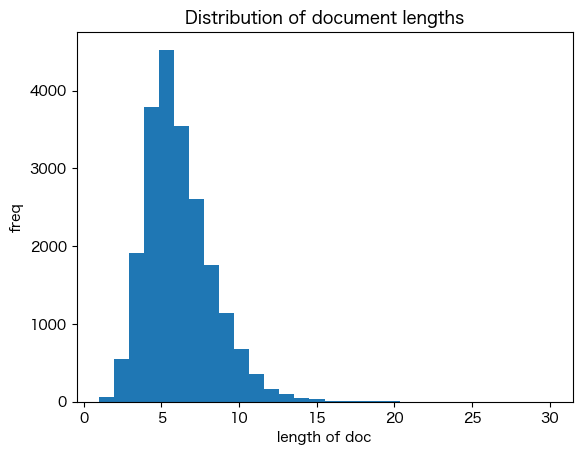

In [2306]:
## 文字数の分布
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(raw_df['size'], bins = 30)
ax.set_xlabel('length of doc')
ax.set_ylabel('freq')
plt.title(f"Distribution of document lengths")
fig.show()

データを長さで濾過

In [2307]:
## 長過ぎる語の除外 
print(f"max doc size: {max_doc_size}")
original_size = len(raw_df)
raw_df = raw_df[raw_df['size'] <= max_doc_size]
max_filtered_size = len(raw_df)
print(f"{original_size - max_filtered_size} cases removed due to max_doc_size")

## 短過ぎる語の除外
print(f"min doc size: {min_doc_size}")
raw_df = raw_df[raw_df['size'] >= min_doc_size]
min_filtered_size = len(raw_df)
print(f"{max_filtered_size - min_filtered_size} cases removed due to min_doc_size")
#
print(f"{original_size - min_filtered_size} cases removed in total")

max doc size: 15
42 cases removed due to max_doc_size
min doc size: 3
620 cases removed due to min_doc_size
662 cases removed in total


In [2308]:
## 結果の検査 1
for type in types:
    print(raw_df[type].value_counts(sort = True))

spell
1    20658
Name: count, dtype: int64
sound
0    20658
Name: count, dtype: int64


In [2309]:
## 結果の検査 2
for lang in selected_langs:
    print(raw_df[lang].value_counts(sort = True).sort_index())

arabic
0    19712
1      946
Name: count, dtype: int64
czech
0    19702
1      956
Name: count, dtype: int64
hebrew
0    19741
1      917
Name: count, dtype: int64
dutch
0    19689
1      969
Name: count, dtype: int64
english
0    16413
1     4245
Name: count, dtype: int64
esperanto
0    19976
1      682
Name: count, dtype: int64
finnish
0    19673
1      985
Name: count, dtype: int64
french
0    19690
1      968
Name: count, dtype: int64
german
0    19878
1      780
Name: count, dtype: int64
greek
0    19683
1      975
Name: count, dtype: int64
hungarian
0    19716
1      942
Name: count, dtype: int64
icelandic
0    19834
1      824
Name: count, dtype: int64
irish
0    19720
1      938
Name: count, dtype: int64
romanian
0    20658
Name: count, dtype: int64
russian
0    19699
1      959
Name: count, dtype: int64
italian
0    19691
1      967
Name: count, dtype: int64
spanish
0    19691
1      967
Name: count, dtype: int64
swahili
0    19958
1      700
Name: count, dtype: int64
turkish


英語事例の割合補正

In [2310]:
## 統合: 割合補正を適用
eng_reduct_factor = 0.2
if balanced:
    try:
        eng_df = raw_df[raw_df['english'] == 1]
        non_eng_df = raw_df[raw_df['english'] == 0]
        eng_reduced_df = eng_df.sample(round(len(eng_df) * eng_reduct_factor))
        raw_df = pd.concat([eng_reduced_df, non_eng_df])
    except KeyError:
        pass
#
raw_df

,form,freq,spell,sound,arabic,czech,hebrew,dutch,english,esperanto,...,romanian,russian,italian,spanish,swahili,turkish,welsh,language,family,size
126,among,1.0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,english,english,5
2425,mroczka,1.0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,english,english,7
1684,grueling,1.0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,english,english,8
93,akin,1.0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,english,english,4
1127,drawdown,1.0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,english,english,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,trwyn,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,5
996,lluosog,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7
997,dicter,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,6
998,hawliad,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7


In [2311]:
## 結果の検査 3
for lang in selected_langs:
    print(raw_df[lang].value_counts().sort_index())

arabic
0    16316
1      946
Name: count, dtype: int64
czech
0    16306
1      956
Name: count, dtype: int64
hebrew
0    16345
1      917
Name: count, dtype: int64
dutch
0    16293
1      969
Name: count, dtype: int64
english
0    16413
1      849
Name: count, dtype: int64
esperanto
0    16580
1      682
Name: count, dtype: int64
finnish
0    16277
1      985
Name: count, dtype: int64
french
0    16294
1      968
Name: count, dtype: int64
german
0    16482
1      780
Name: count, dtype: int64
greek
0    16287
1      975
Name: count, dtype: int64
hungarian
0    16320
1      942
Name: count, dtype: int64
icelandic
0    16438
1      824
Name: count, dtype: int64
irish
0    16324
1      938
Name: count, dtype: int64
romanian
0    17262
Name: count, dtype: int64
russian
0    16303
1      959
Name: count, dtype: int64
italian
0    16295
1      967
Name: count, dtype: int64
spanish
0    16295
1      967
Name: count, dtype: int64
swahili
0    16562
1      700
Name: count, dtype: int64
turkish


# 解析

In [2312]:
## 順序のランダマイズし，基本データを決定
import sklearn.utils
main_df = sklearn.utils.shuffle(raw_df)

DTM 構築の準備

In [2313]:
## ngram の追加

## module 探索範囲の拡張
import sys
sys.path.append('..')

import re
import ngrams
import importlib
importlib.reload(ngrams)
import ngrams_skippy

# name the shared variable
bases = main_df[doc_type]

In [2314]:
## 1gram 列の追加
unigrams = ngrams.gen_unigrams(bases, sep = r"", check = False)
unigrams = [ [ u for u in L if len(u) > 0 ] for L in unigrams ]
if verbose:
    random.sample(unigrams, 5)
#
main_df['1gram'] = unigrams
main_df

,form,freq,spell,sound,arabic,czech,hebrew,dutch,english,esperanto,...,russian,italian,spanish,swahili,turkish,welsh,language,family,size,1gram
303,فتاة,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,arabic,arabic,4,"[ف, ت, ا, ة]"
209,crescere,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,italian,romance,8,"[c, r, e, s, c, e, r, e]"
649,δεκαδικό,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,greek,greek,8,"[δ, ε, κ, α, δ, ι, κ, ό]"
337,صخرة,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,arabic,arabic,4,"[ص, خ, ر, ة]"
814,ag brath,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,irish,celtic,8,"[a, g, , b, r, a, t, h]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,rész,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,hungarian,hungarian,4,"[r, é, s, z]"
339,zuiden,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,dutch,germanic,6,"[z, u, i, d, e, n]"
438,meleg,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,hungarian,hungarian,5,"[m, e, l, e, g]"
921,направлять,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,russian,russian,10,"[н, а, п, р, а, в, л, я, т, ь]"


In [2315]:
## 2gram列の追加
bigrams = ngrams.gen_bigrams(bases, sep = r"", check = False)

## 包括的 2gram の作成
if ngram_is_inclusive:
    bigrams = [ [*b, *u] for b, u in zip(bigrams, unigrams) ]
#
if verbose:
    print(random.sample(bigrams, 3))

In [2316]:
main_df['2gram'] = bigrams
if verbose:
    main_df

In [2317]:
## 3gram列の追加
trigrams = ngrams.gen_trigrams(bases, sep = r"", check = False)

## 包括的 3gram の作成
if ngram_is_inclusive:
    trigrams = [ [ *t, *b ] for t, b in  zip(trigrams, bigrams) ]
#
if verbose:
    print(random.sample(trigrams, 3))

In [2318]:
main_df['3gram'] = trigrams
if verbose:
    main_df

In [2319]:
## skippy 2grams の生成
import ngrams_skippy
skippy_2grams = [ ngrams_skippy.gen_skippy_bigrams(x, missing_mark = gap_mark,
                                                    max_distance = max_ga_val, check = False)
                  for x in main_df['1gram'] ]

## 包括的 skippy 2-grams の生成
if ngram_is_inclusive:
    for i, b2 in enumerate(skippy_2grams):
        b2.extend(unigrams[i])
#
if verbose:
    random.sample(skippy_2grams, 3)

In [2320]:
## skippy 2gram 列の追加
main_df['skippy2gram'] = skippy_2grams
main_df

,form,freq,spell,sound,arabic,czech,hebrew,dutch,english,esperanto,...,swahili,turkish,welsh,language,family,size,1gram,2gram,3gram,skippy2gram
303,فتاة,1,1,0,1,0,0,0,0,0,...,0,0,0,arabic,arabic,4,"[ف, ت, ا, ة]","[فت, تا, اة, ف, ت, ا, ة]","[فتا, تاة, فت, تا, اة, ف, ت, ا, ة]","[فت, ف…ا, ف…ة, تا, ت…ة, اة, ف, ت, ا, ة]"
209,crescere,1,1,0,0,0,0,0,0,0,...,0,0,0,italian,romance,8,"[c, r, e, s, c, e, r, e]","[cr, re, es, sc, ce, er, re, c, r, e, s, c, e,...","[cre, res, esc, sce, cer, ere, cr, re, es, sc,...","[cr, c…e, c…s, c…c, c…r, re, r…s, r…c, r…e, r…..."
649,δεκαδικό,1,1,0,0,0,0,0,0,0,...,0,0,0,greek,greek,8,"[δ, ε, κ, α, δ, ι, κ, ό]","[δε, εκ, κα, αδ, δι, ικ, κό, δ, ε, κ, α, δ, ι,...","[δεκ, εκα, καδ, αδι, δικ, ικό, δε, εκ, κα, αδ,...","[δε, δ…κ, δ…α, δ…δ, δ…ι, δ…ό, εκ, ε…α, ε…δ, ε…..."
337,صخرة,1,1,0,1,0,0,0,0,0,...,0,0,0,arabic,arabic,4,"[ص, خ, ر, ة]","[صخ, خر, رة, ص, خ, ر, ة]","[صخر, خرة, صخ, خر, رة, ص, خ, ر, ة]","[صخ, ص…ر, ص…ة, خر, خ…ة, رة, ص, خ, ر, ة]"
814,ag brath,1,1,0,0,0,0,0,0,0,...,0,0,0,irish,celtic,8,"[a, g, , b, r, a, t, h]","[ag, g , b, br, ra, at, th, a, g, , b, r, a,...","[ag , g b, br, bra, rat, ath, ag, g , b, br,...","[ag, a… , a…b, a…r, a…a, a…t, a…h, g , g…b, g…..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,rész,1,1,0,0,0,0,0,0,0,...,0,0,0,hungarian,hungarian,4,"[r, é, s, z]","[ré, és, sz, r, é, s, z]","[rés, ész, ré, és, sz, r, é, s, z]","[ré, r…s, r…z, és, é…z, sz, r, é, s, z]"
339,zuiden,1,1,0,0,0,0,1,0,0,...,0,0,0,dutch,germanic,6,"[z, u, i, d, e, n]","[zu, ui, id, de, en, z, u, i, d, e, n]","[zui, uid, ide, den, zu, ui, id, de, en, z, u,...","[zu, z…i, z…d, z…e, z…n, ui, u…d, u…e, u…n, id..."
438,meleg,1,1,0,0,0,0,0,0,0,...,0,0,0,hungarian,hungarian,5,"[m, e, l, e, g]","[me, el, le, eg, m, e, l, e, g]","[mel, ele, leg, me, el, le, eg, m, e, l, e, g]","[me, m…l, m…e, m…g, el, e…e, e…g, le, l…g, eg,..."
921,направлять,1,1,0,0,0,0,0,0,0,...,0,0,0,russian,russian,10,"[н, а, п, р, а, в, л, я, т, ь]","[на, ап, пр, ра, ав, вл, ля, ят, ть, н, а, п, ...","[нап, апр, пра, рав, авл, вля, лят, ять, на, а...","[на, н…п, н…р, н…а, н…в, н…л, н…я, н…т, н…ь, а..."


In [2321]:
## skippy 3grams の生成
import ngrams_skippy
skippy_3grams = [ ngrams_skippy.gen_skippy_trigrams(x, missing_mark = gap_mark,
                                                         max_distance = max_ga_val, check = False)
                  for x in main_df['1gram'] ]

## 包括的 skippy 3-grams の生成
if ngram_is_inclusive:
    for i, t2 in enumerate(skippy_3grams):
        t2.extend(skippy_2grams[i])
#
if verbose:
    random.sample(skippy_3grams, 3)

In [2322]:
## skippy 3gram 列の追加
main_df['skippy3gram'] = skippy_3grams
main_df

,form,freq,spell,sound,arabic,czech,hebrew,dutch,english,esperanto,...,turkish,welsh,language,family,size,1gram,2gram,3gram,skippy2gram,skippy3gram
303,فتاة,1,1,0,1,0,0,0,0,0,...,0,0,arabic,arabic,4,"[ف, ت, ا, ة]","[فت, تا, اة, ف, ت, ا, ة]","[فتا, تاة, فت, تا, اة, ف, ت, ا, ة]","[فت, ف…ا, ف…ة, تا, ت…ة, اة, ف, ت, ا, ة]","[فتا, فت…ة, ف…اة, تاة, فت, ف…ا, ف…ة, تا, ت…ة, ..."
209,crescere,1,1,0,0,0,0,0,0,0,...,0,0,italian,romance,8,"[c, r, e, s, c, e, r, e]","[cr, re, es, sc, ce, er, re, c, r, e, s, c, e,...","[cre, res, esc, sce, cer, ere, cr, re, es, sc,...","[cr, c…e, c…s, c…c, c…r, re, r…s, r…c, r…e, r…...","[cre, cr…s, cr…c, cr…e, cr…r, c…es, c…e…c, c…e..."
649,δεκαδικό,1,1,0,0,0,0,0,0,0,...,0,0,greek,greek,8,"[δ, ε, κ, α, δ, ι, κ, ό]","[δε, εκ, κα, αδ, δι, ικ, κό, δ, ε, κ, α, δ, ι,...","[δεκ, εκα, καδ, αδι, δικ, ικό, δε, εκ, κα, αδ,...","[δε, δ…κ, δ…α, δ…δ, δ…ι, δ…ό, εκ, ε…α, ε…δ, ε…...","[δεκ, δε…α, δε…δ, δε…ι, δε…κ, δε…ό, δ…κα, δ…κ…..."
337,صخرة,1,1,0,1,0,0,0,0,0,...,0,0,arabic,arabic,4,"[ص, خ, ر, ة]","[صخ, خر, رة, ص, خ, ر, ة]","[صخر, خرة, صخ, خر, رة, ص, خ, ر, ة]","[صخ, ص…ر, ص…ة, خر, خ…ة, رة, ص, خ, ر, ة]","[صخر, صخ…ة, ص…رة, خرة, صخ, ص…ر, ص…ة, خر, خ…ة, ..."
814,ag brath,1,1,0,0,0,0,0,0,0,...,0,0,irish,celtic,8,"[a, g, , b, r, a, t, h]","[ag, g , b, br, ra, at, th, a, g, , b, r, a,...","[ag , g b, br, bra, rat, ath, ag, g , b, br,...","[ag, a… , a…b, a…r, a…a, a…t, a…h, g , g…b, g…...","[ag , ag…b, ag…r, ag…a, ag…t, ag…h, a… b, a… …..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,rész,1,1,0,0,0,0,0,0,0,...,0,0,hungarian,hungarian,4,"[r, é, s, z]","[ré, és, sz, r, é, s, z]","[rés, ész, ré, és, sz, r, é, s, z]","[ré, r…s, r…z, és, é…z, sz, r, é, s, z]","[rés, ré…z, r…sz, ész, ré, r…s, r…z, és, é…z, ..."
339,zuiden,1,1,0,0,0,0,1,0,0,...,0,0,dutch,germanic,6,"[z, u, i, d, e, n]","[zu, ui, id, de, en, z, u, i, d, e, n]","[zui, uid, ide, den, zu, ui, id, de, en, z, u,...","[zu, z…i, z…d, z…e, z…n, ui, u…d, u…e, u…n, id...","[zui, zu…d, zu…e, zu…n, z…id, z…i…e, z…i…n, z…..."
438,meleg,1,1,0,0,0,0,0,0,0,...,0,0,hungarian,hungarian,5,"[m, e, l, e, g]","[me, el, le, eg, m, e, l, e, g]","[mel, ele, leg, me, el, le, eg, m, e, l, e, g]","[me, m…l, m…e, m…g, el, e…e, e…g, le, l…g, eg,...","[mel, me…e, me…g, m…le, m…l…g, m…eg, ele, el…g..."
921,направлять,1,1,0,0,0,0,0,0,0,...,0,0,russian,russian,10,"[н, а, п, р, а, в, л, я, т, ь]","[на, ап, пр, ра, ав, вл, ля, ят, ть, н, а, п, ...","[нап, апр, пра, рав, авл, вля, лят, ять, на, а...","[на, н…п, н…р, н…а, н…в, н…л, н…я, н…т, н…ь, а...","[нап, на…р, на…а, на…в, на…л, на…я, на…т, на…ь..."


DTM 構築

In [2323]:
## LDA 構築の基になる document-term matrix (dtm) を構築
from gensim.corpora.dictionary import Dictionary
bots = main_df[lda_term_type] # 後で参照するので変数化しておく
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<9076 unique tokens: ['ا', 'اة', 'ة', 'ت', 'تا']...>


In [2324]:
## diction の濾過
import copy
diction_copy = copy.deepcopy(diction)

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
print(f"min freq filter: {term_min_freq}")
print(f"abuse filter: {term_abuse_threshold}")

apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = term_min_freq, no_above = term_abuse_threshold)

## check
print(diction_copy)

min freq filter: 1
abuse filter: 0.003
Dictionary<8060 unique tokens: ['اة', 'تا', 'ت…ة', 'فت', 'ف…ا']...>


In [2325]:
## Corpus (gensim の用語では corpus) の構築
corpus = [ diction.doc2bow(bot) for bot in bots ]

## check
check = True
if verbose:
    sample_n = 5
    print(random.sample(corpus, sample_n))
#
print(f"Number of documents: {len(corpus)}")

Number of documents: 17262


LDA モデルの構築

In [2326]:
## LDA モデルの構築

from gensim.models import LdaModel as LDAmodel
print(f"Building LDA model with n_topics: {n_topics}")
doc_lda = LDAmodel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
print(doc_lda) # print(..)しないと中身が見れない

Building LDA model with n_topics: 10


LdaModel<num_terms=9076, num_topics=10, decay=0.5, chunksize=2000>


In [2327]:
%%capture --no-display

## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 30 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in doc_lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10
0,a,a,c,w,α,e,v,e,о,a
1,h,t,o,f,ο,n,i,r,а,r
2,u,o,i,d,ρ,s,d,i,ا,p
3,m,s,s,w…n,,z,e,t,е,b
4,n,i,p,w…r,ι,u,y,g,т,e
5,o,k,u,we,τ,k,l,e…e,ו,t
6,c,l,e,w…d,ε,en,n,er,י,n
7,e,r,n,w…e,ν,i,o,r…e,р,o
8,i,n,c…e,wa,π,e…n,t,re,и,a…e
9,d,a…a,c…i,f…d,μ,e…e,ve,e…r,н,m


LDAvis の実行

In [2328]:
%%capture --no-display

## pyLDAvis を使った結果 LDA の可視化: 階層クラスタリングより詳しい
import pyLDAvis
installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")

if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()
#
lda_used     = doc_lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター: MMDS かtSNEを選ぶと "JSON object is too complex" error を回避できる 
LDAvis_use_MMDS  = False
LDAvis_use_tSNE  = False
if LDAvis_use_MMDS:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)
elif LDAvis_use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [2329]:
## LDA がD に対して生成した topics の弁別性を確認
## 得られたtopics を確認
topic_dist = doc_lda.get_topics()
if verbose:
    topic_dist

In [2330]:
## 検査 1: topic ごとに分布の和を取る
print(topic_dist.sum(axis = 1))

[1.         1.         0.99999994 1.0000001  1.         1.0000001
 1.         1.         0.9999999  0.99999994]


In [2331]:
## 検査 2: 総和を求める: n_topics にほぼ等しいなら正常
print(topic_dist.sum())

9.999999


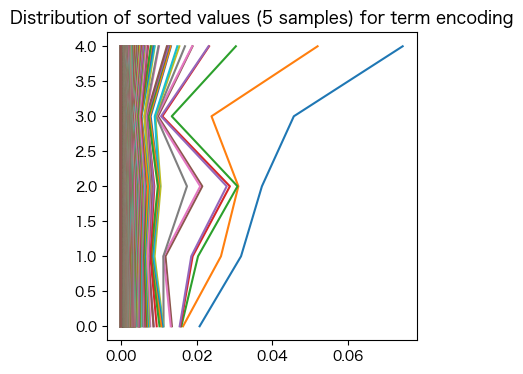

In [2332]:
## term エンコード値の分布を確認

import matplotlib.pyplot as plt

plt.figure(figsize = (4,4))
df_size = len(topic_dist)
sampling_rate = 0.5
sample_n = round(df_size * sampling_rate)
topic_sampled = random.sample(list(topic_dist), sample_n)

T = sorted([ sorted(x, reverse = True) for x in topic_sampled ])
plt.plot(T, range(len(T)))
plt.title(f"Distribution of sorted values ({sample_n} samples) for term encoding")
plt.show()

In [2333]:
## tSNE を使った topics のグループ化 (3D)

from sklearn.manifold import TSNE as tSNE
import numpy as np

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
ppl_val = round(len(topic_dist) * top_perplexity_reduct_rate)
top_tSNE_3d = tSNE(n_components = 3, random_state = 0, perplexity = ppl_val, n_iter = 1000)

## データに適用
top_tSNE_3d_fitted = top_tSNE_3d.fit_transform(np.array(topic_dist))

In [2334]:
## Plotlyを使って tSNE の結果の可視化 (3D)

import plotly.graph_objects as go
top_fitted = top_tSNE_3d_fitted
fig = go.Figure(data = [go.Scatter3d(
        x = top_fitted[:,0], y = top_fitted[:,1], z = top_fitted[:,2],
                                     mode = 'markers')
                                     ])

## 3D 散布図にラベルを追加する処理は未実装
title_val = f"t-SNE 3D map of LDA topics (#topics: {n_topics}; doc: {doc_attr}; term: {lda_term_type})"
fig.update_layout(autosize = False, width = 600, height = 600, title = title_val)
fig.show()

# doc 分類

In [2335]:
main_df

,form,freq,spell,sound,arabic,czech,hebrew,dutch,english,esperanto,...,turkish,welsh,language,family,size,1gram,2gram,3gram,skippy2gram,skippy3gram
303,فتاة,1,1,0,1,0,0,0,0,0,...,0,0,arabic,arabic,4,"[ف, ت, ا, ة]","[فت, تا, اة, ف, ت, ا, ة]","[فتا, تاة, فت, تا, اة, ف, ت, ا, ة]","[فت, ف…ا, ف…ة, تا, ت…ة, اة, ف, ت, ا, ة]","[فتا, فت…ة, ف…اة, تاة, فت, ف…ا, ف…ة, تا, ت…ة, ..."
209,crescere,1,1,0,0,0,0,0,0,0,...,0,0,italian,romance,8,"[c, r, e, s, c, e, r, e]","[cr, re, es, sc, ce, er, re, c, r, e, s, c, e,...","[cre, res, esc, sce, cer, ere, cr, re, es, sc,...","[cr, c…e, c…s, c…c, c…r, re, r…s, r…c, r…e, r…...","[cre, cr…s, cr…c, cr…e, cr…r, c…es, c…e…c, c…e..."
649,δεκαδικό,1,1,0,0,0,0,0,0,0,...,0,0,greek,greek,8,"[δ, ε, κ, α, δ, ι, κ, ό]","[δε, εκ, κα, αδ, δι, ικ, κό, δ, ε, κ, α, δ, ι,...","[δεκ, εκα, καδ, αδι, δικ, ικό, δε, εκ, κα, αδ,...","[δε, δ…κ, δ…α, δ…δ, δ…ι, δ…ό, εκ, ε…α, ε…δ, ε…...","[δεκ, δε…α, δε…δ, δε…ι, δε…κ, δε…ό, δ…κα, δ…κ…..."
337,صخرة,1,1,0,1,0,0,0,0,0,...,0,0,arabic,arabic,4,"[ص, خ, ر, ة]","[صخ, خر, رة, ص, خ, ر, ة]","[صخر, خرة, صخ, خر, رة, ص, خ, ر, ة]","[صخ, ص…ر, ص…ة, خر, خ…ة, رة, ص, خ, ر, ة]","[صخر, صخ…ة, ص…رة, خرة, صخ, ص…ر, ص…ة, خر, خ…ة, ..."
814,ag brath,1,1,0,0,0,0,0,0,0,...,0,0,irish,celtic,8,"[a, g, , b, r, a, t, h]","[ag, g , b, br, ra, at, th, a, g, , b, r, a,...","[ag , g b, br, bra, rat, ath, ag, g , b, br,...","[ag, a… , a…b, a…r, a…a, a…t, a…h, g , g…b, g…...","[ag , ag…b, ag…r, ag…a, ag…t, ag…h, a… b, a… …..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,rész,1,1,0,0,0,0,0,0,0,...,0,0,hungarian,hungarian,4,"[r, é, s, z]","[ré, és, sz, r, é, s, z]","[rés, ész, ré, és, sz, r, é, s, z]","[ré, r…s, r…z, és, é…z, sz, r, é, s, z]","[rés, ré…z, r…sz, ész, ré, r…s, r…z, és, é…z, ..."
339,zuiden,1,1,0,0,0,0,1,0,0,...,0,0,dutch,germanic,6,"[z, u, i, d, e, n]","[zu, ui, id, de, en, z, u, i, d, e, n]","[zui, uid, ide, den, zu, ui, id, de, en, z, u,...","[zu, z…i, z…d, z…e, z…n, ui, u…d, u…e, u…n, id...","[zui, zu…d, zu…e, zu…n, z…id, z…i…e, z…i…n, z…..."
438,meleg,1,1,0,0,0,0,0,0,0,...,0,0,hungarian,hungarian,5,"[m, e, l, e, g]","[me, el, le, eg, m, e, l, e, g]","[mel, ele, leg, me, el, le, eg, m, e, l, e, g]","[me, m…l, m…e, m…g, el, e…e, e…g, le, l…g, eg,...","[mel, me…e, me…g, m…le, m…l…g, m…eg, ele, el…g..."
921,направлять,1,1,0,0,0,0,0,0,0,...,0,0,russian,russian,10,"[н, а, п, р, а, в, л, я, т, ь]","[на, ап, пр, ра, ав, вл, ля, ят, ть, н, а, п, ...","[нап, апр, пра, рав, авл, вля, лят, ять, на, а...","[на, н…п, н…р, н…а, н…в, н…л, н…я, н…т, н…ь, а...","[нап, на…р, на…а, на…в, на…л, на…я, на…т, на…ь..."


In [2336]:
## LDA モデルを使って doc をエンコード

print(f"get LDA encodings for documents")
check    = False
lda_encoding = [ ]
for i, row in main_df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[lda_term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = doc_lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc: {enc}")
    lda_encoding.append([ e[-1] for e in enc ])
#
print(random.sample(lda_encoding, 2))
print(len(lda_encoding))

get LDA encodings for documents
[[0.0009902827, 0.0009902827, 0.0009902827, 0.0009902827, 0.0009902827, 0.3232654, 0.0009902827, 0.66881233, 0.0009902827, 0.0009902827], [0.00033227808, 0.00033227808, 0.00033227808, 0.00033227808, 0.00033227808, 0.49435917, 0.00033227808, 0.24528828, 0.00033227808, 0.25802663]]
17262


In [2337]:
## FastText を使ったエンコードの準備
from gensim.models import FastText

## build a model: for better comparison, vector_size should be equal to n_topics
print(f"get FastText encodings for documents")

#ft_corpus = df[doc_type]
## emulate sentences by concatenating character 1-grams by whitespaces
ft_corpus = [ " ".join(x) for x in main_df[ft_term_type] ]
random.sample(ft_corpus, 3)


get FastText encodings for documents


['ar  r a  a  a l  la lag agh gha had ar r   a a   l la ag gh ha ad a r   a   l a g h a d',
 'كما كم ما ك م ا',
 'pár pá ár p á r']

In [2338]:
## FastText を使ったエンコード
ft_model = FastText(ft_corpus,
                    vector_size = ft_n_dims,
                    window = ft_window_size,
                    min_count = 1, sg = 1)
## ft_model は dict
ft_encoding = [ ft_model.wv[doc] for doc in ft_corpus ]
print(random.sample(ft_encoding, 1))
print(f"data size: {len(ft_encoding)}")

[array([-4.3688379e-03, -3.3230742e-04, -2.7554191e-04,  1.4125801e-03,
       -2.8083897e-03,  3.5255395e-03,  9.1476511e-04, -9.9312549e-04,
        7.0305192e-04, -8.1170193e-04,  1.0747537e-03,  1.9975554e-03,
        1.2643613e-03,  1.8017812e-03,  3.0046303e-03,  6.6844630e-03,
        6.7273642e-05,  2.3355475e-03,  8.0347981e-04,  1.3483854e-04],
      dtype=float32)]
data size: 17262


In [2339]:
## doc_encoding の選択

if use_FastText:
    if use_LDA: ## LDA x FastText
        doc_encoding = [ np.concatenate([x, y], dtype = object) for x, y in zip(lda_encoding, ft_encoding) ]
    else: ## FastText only
        doc_encoding = ft_encoding
else: ## LDA only
    doc_encoding = lda_encoding
#
print(random.sample(doc_encoding, 1))
print(f"data size: {len(doc_encoding)}")

[array([0.0009910392109304667, 0.0009910392109304667,
       0.0009910392109304667, 0.0009910392109304667,
       0.0009910392109304667, 0.29792320728302, 0.09967248886823654,
       0.0009910392109304667, 0.5954670310020447, 0.0009910392109304667,
       -0.0006957752630114555, 0.0015918349381536245,
       -0.0030122618190944195, 0.0012834947556257248,
       0.0017069353489205241, 0.005562450271099806,
       -0.0053792246617376804, -0.005533503368496895,
       0.001894697081297636, -0.00011973604705417529,
       4.0545604861108586e-05, 0.0072195446118712425,
       -0.001984833274036646, 0.0017801683861762285, 0.006528179626911879,
       0.002945560496300459, 0.001054163440130651, -0.0019804202020168304,
       -0.0010214205831289291, 0.0013791711535304785], dtype=object)]
data size: 17262


In [2340]:
## df にenc 列の追加
#df['enc'] = [ list(map(lambda x: x[1], y)) for y in doc_encoding ]
main_df['enc'] = doc_encoding
main_df['enc']

303    [0.0009904567850753665, 0.0009904567850753665,...
209    [0.000369016284821555, 0.000369016284821555, 0...
649    [0.00030221673659980297, 0.0003022167365998029...
337    [0.0010962816886603832, 0.3338068127632141, 0....
814    [0.3127301037311554, 0.0002849911688826978, 0....
                             ...                        
103    [0.0009902793681249022, 0.0009902793681249022,...
339    [0.0004739670839626342, 0.0004739670839626342,...
438    [0.38210034370422363, 0.000662281468976289, 0....
921    [0.00019845199130941182, 0.0001984519913094118...
447    [0.0019470327533781528, 0.0019470327533781528,...
Name: enc, Length: 17262, dtype: object

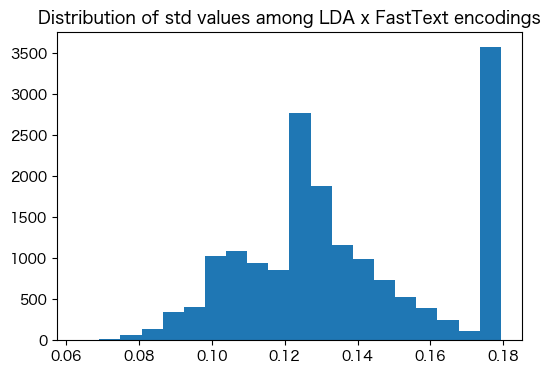

In [2341]:
## 濾過前のエンコーディングのstd の分布を確認

import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize = (6,4))
plt.hist([ np.std(x) for x in main_df['enc'] ], bins = 20)
plt.title(f"Distribution of std values among {encoding_method} encodings")
plt.show()

In [2342]:
## 一様分布の事例を除外

import numpy as np

check = False
doc_enc = main_df['enc']
max_std = max([ np.std(x) for x in doc_enc])
if check:
    print(f"std max: {max_std}")

min_std = min([ np.std(x) for x in doc_enc])
if check:
    print(f"std min: {min_std}")

first_min_std = list(sorted(set([ np.std(x) for x in doc_enc])))[-0]
print(f"std 1st min: {first_min_std}")

second_min_std = list(sorted(set([ np.std(x) for x in doc_enc])))[-1]
print(f"std 2nd min: {second_min_std}")

std 1st min: 0.06331064113420579
std 2nd min: 0.17933197982523458


In [2343]:
## df_filtered の定義
import numpy as np

print(f"{len(main_df)} instances before filtering")

## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき
std_threshold = second_min_std / 6 # 穏健な値を得るために 6で割った
print(f"std_threshold: {std_threshold}")

## Rっぽい次のコードは通らない
#df_filtered = df[ df['encoding'] > std_threshold ]
## 通るのは次のコード: Creating a list of True/False and apply it to DataFrame 
std_tested = [ False if np.std(x) < std_threshold else True for x in main_df['enc'] ]
df_filtered = main_df[ std_tested ]
print(f"Filtering leaves {len(df_filtered)} instances: ({len(main_df) - len(df_filtered)} instances removed)")

17262 instances before filtering
std_threshold: 0.029888663304205764
Filtering leaves 17262 instances: (0 instances removed)


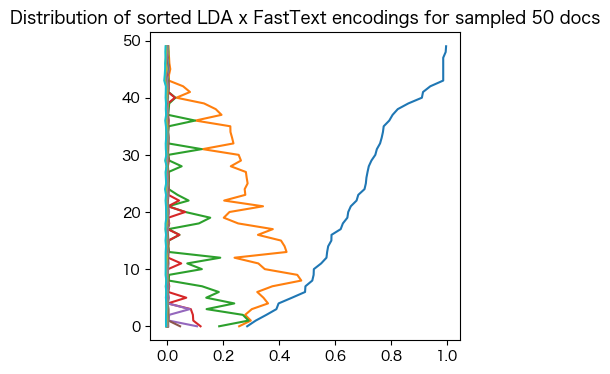

In [2344]:
## doc エンコード値の分布を確認

sample_n = 50
E = sorted([ sorted(x, reverse = True) for x in df_filtered['enc'].sample(sample_n) ])
plt.figure(figsize = (4,4))
plt.plot(E, range(len(E)))
plt.title(f"Distribution of sorted {encoding_method} encodings for sampled {sample_n} docs")
plt.show()

In [2345]:
df_filtered['language'].value_counts(sort = True).sort_index()

language
arabic       946
czech        956
dutch        969
english      849
esperanto    682
finnish      985
french       968
german       780
greek        975
hebrew       917
hungarian    942
icelandic    824
irish        938
italian      967
russian      959
spanish      967
swahili      700
turkish      967
welsh        971
Name: count, dtype: int64

Dim Reduct 用の事例サンプリング

In [2346]:
## Dim Reduct 用の事例サンプリング = doc_fit_df の定義
if doc_fit_sampling:
    doc_fit_df_original = df_filtered.copy()
    sample_n = round(len(doc_fit_df_original) * doc_fit_sampling_rate)
    doc_fit_df = doc_fit_df_original.sample(sample_n)
    print(f"doc_fit_df has {len(doc_fit_df)} rows after sampling")
else:
    doc_fit_df = df_filtered

doc_fit_df has 3452 rows after sampling


In [2347]:
doc_fit_df.columns

Index(['form', 'freq', 'spell', 'sound', 'arabic', 'czech', 'hebrew', 'dutch',
       'english', 'esperanto', 'finnish', 'french', 'german', 'greek',
       'hungarian', 'icelandic', 'irish', 'romanian', 'russian', 'italian',
       'spanish', 'swahili', 'turkish', 'welsh', 'language', 'family', 'size',
       '1gram', '2gram', '3gram', 'skippy2gram', 'skippy3gram', 'enc'],
      dtype='object')

In [2348]:
doc_fit_df['language'].value_counts(sort = True).sort_index()

language
arabic       169
czech        179
dutch        191
english      162
esperanto    149
finnish      217
french       182
german       168
greek        189
hebrew       195
hungarian    178
icelandic    153
irish        206
italian      195
russian      194
spanish      193
swahili      155
turkish      189
welsh        188
Name: count, dtype: int64

In [2349]:
doc_fit_df['family'].value_counts(sort = True).sort_index()

family
arabic       169
celtic       394
czech        179
english      162
finnish      217
germanic     512
greek        189
hebrew       195
hungarian    178
romance      719
russian      194
swahili      155
turkish      189
Name: count, dtype: int64

UMAP を使った可視化 (3D)

In [2350]:
## UMAP を使った documents のグループ化

import numpy as np
import umap.umap_ as umap

## UMAP の生成
UMAP_3d = umap.UMAP(n_components = 3, random_state = 1, n_jobs = 1,
                    metric = umap_metric,
                    n_neighbors = umap_n_neighbors, min_dist = umap_min_dist)

## データに適用
doc_enc = np.array(list(doc_fit_df['enc']))
doc_UMAP_3d = UMAP_3d.fit_transform(doc_enc)

In [2351]:
%%capture --no-display

## Plotlyを使って UMAP の結果の可視化 (3D)
import plotly.graph_objects as go
import numpy as np

## 色分けの単位を選択
if color_lang_family:
    colored_var = 'family'
else:
    colored_var = 'language'
## umap_df を作成
X = zip(doc_UMAP_3d[:,0], doc_UMAP_3d[:,1], doc_UMAP_3d[:,2],
        doc_fit_df[colored_var], doc_fit_df[doc_type]) # zip(..)が必要
umap_df = pd.DataFrame(X, columns = ['D1', 'D2', 'D3', colored_var, doc_type])
#
fig = go.Figure()
for lang_name in sorted(set(umap_df[colored_var])):
    # set marker size of the target domain
    traced = umap_df[ umap_df['language'] == lang_name ]
    fig.add_trace(
        go.Scatter3d(
            x = traced['D1'], y = traced['D2'], z = traced['D3'],
            name = lang_name.title(),
            mode = 'markers',
            marker = dict(size = 4, opacity = 0.8),
            marker_colorscale = color_palette, # worked??
            showlegend = True
        )
    )

## 3D 散布図にラベルを追加する処理は未実装
df_size = len(df)
## title_header
title_header = f"UMAP 3D (metric: {umap_metric}; {umap_n_neighbors} neighbors; min dist: {umap_min_dist}) of {df_size} encodings via\n"
## title_body
if use_FastText:
    if use_LDA:
        title_body = f"LDA ({n_topics} topics; term:0 {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_body = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
else:
    title_body = f"LDA ({n_topics} topics; term: {lda_term_type})"
#
title_val = title_header + title_body
fig.update_layout(title = dict(text = title_val, font_size = 12), autosize = False, width = 700, height = 700)
fig.show()

t-SNE の結果の可視化 (3D)

In [2352]:
## tSNE の結果の可視化: Plotly を使った 3D 描画

import numpy as np
from sklearn.manifold import TSNE as tSNE
import plotly.express as pex
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## tSNE のパラメターを設定
max_perplexity_factor = 3
perplexity_max_val = round(len(doc_fit_df)/max_perplexity_factor)
print(f"perplexity_max_val: {perplexity_max_val}")

divider = 5
perplexity_increment = round(perplexity_max_val/divider)
print(f"perplexity_increment: {perplexity_increment}")

## tSNE を段階的に実行
df_size = len(doc_fit_df)
exit_after_step = 3 # 15 is largest enough to complete the all steps
ppl_vals = enumerate(range(5, perplexity_max_val, perplexity_increment))
for step, ppl_val in ppl_vals:
    ## 早期終了の判定
    if step >= exit_after_step:
        continue
    ## tSNE 事例の生成
    tSNE_3d_varied = tSNE(n_components = 3, random_state = 0, perplexity = ppl_val,
                          n_iter = 1000)

    ## データに適用
    doc_enc = np.array(list(doc_fit_df['enc']))
    doc_tSNE_3d_varied = tSNE_3d_varied.fit_transform(doc_enc)

    ## 色分けの単位を選択
    if color_lang_family:
        colored_var = 'family'
    else:
        colored_var = 'language'
    ##
    X = zip(doc_tSNE_3d_varied[:,0], doc_tSNE_3d_varied[:,1], doc_tSNE_3d_varied[:,2],
            doc_fit_df[colored_var]) # zip(..)が必要
    dfx = pd.DataFrame(X, columns = ['D1', 'D2', 'D3', colored_var])
    ## 作図
    fig = go.Figure()
    for lang in np.unique(main_df[colored_var]):
        traced = dfx[dfx[colored_var] == lang]
        fig.add_trace(
            go.Scatter3d(
                x = traced['D1'], y = traced['D2'], z = traced['D3'],
                name = lang.title(), mode = 'markers', marker = dict(size = 3),
                marker_colorscale = color_palette, # worked??
                showlegend = True
            )
        )
    ## 題の指定
    title_header = f"t-SNE 3D map (ppl: {ppl_val}) of {df_size} encodings for <{doc_attr}> via\n"
    if use_FastText:
        if use_LDA:
            title_body = f"LDA ({n_topics} topics; term: {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
        else:
            title_body = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_body = f"LDA ({n_topics} topics; term: {lda_term_type})"
    title_val = title_header + title_body
    fig.update_layout(title = dict(text = title_val, font_size = 13),
                      autosize = False, width = 600, height = 600)
    fig.show()

perplexity_max_val: 1151
perplexity_increment: 230


In [2353]:
## 必要に応じて adjustText を道入
#!pip install -U adjustText

t-SNE の結果の可視化 (2D)

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/adjustText/__init__.py:564: UserWarning:

Glyph 942 (\N{GREEK SMALL LETTER ETA WITH TONOS}) missing from current font.

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/adjustText/__init__.py:564: UserWarning:

Glyph 1514 (\N{HEBREW LETTER TAV}) missing from current font.

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/adjustText/__init__.py:564: UserWarning:

Matplotlib currently does not support Hebrew natively.

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/adjustText/__init__.py:564: UserWarning:

Glyph 1489 (\N{HEBREW LETTER BET}) missing from current font.

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/adjustText/__init__.py:564: UserWarning:

Glyph 1493 (\N{HEBREW LETTER VAV}) missing from current font.

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/adjustText/__init__.py:564: UserWarning:

Glyph 1488 (\N{HEBREW LETTER ALEF}) missing from current font.

/Volumes/K/opt/miniconda3/lib/p

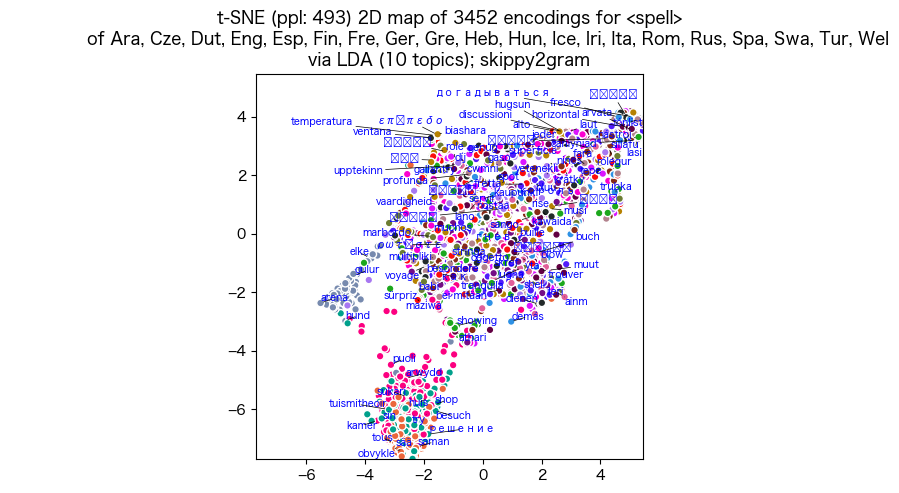

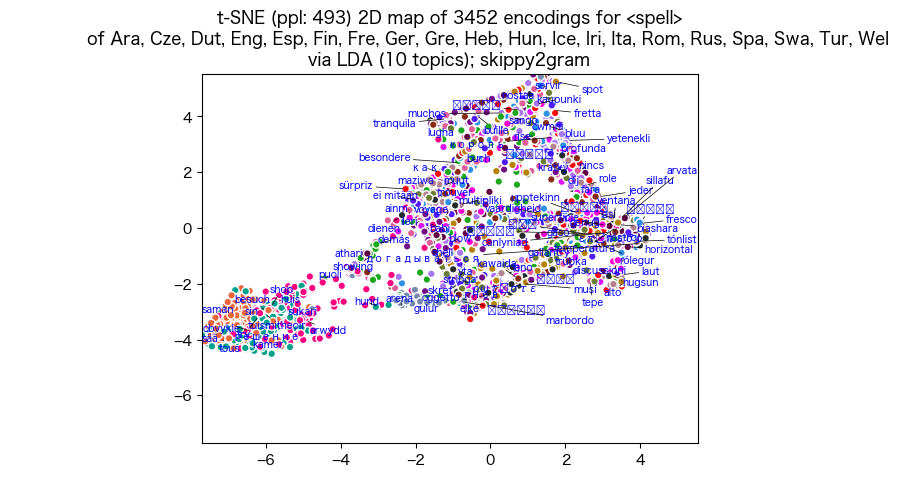

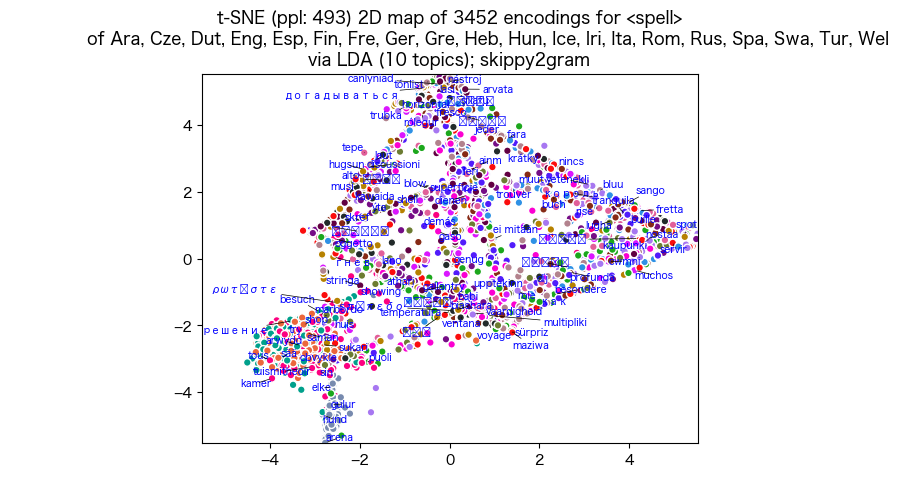

In [2354]:
## tSNE の結果の可視化 (2D)

import numpy as np
from sklearn.manifold import TSNE as tSNE
import plotly
import plotly.express as pex
import matplotlib.pyplot as plt
from adjustText import adjust_text

## 次の設定は arabic が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある

## tSNE 事例の生成
ppl_divider = 7
perplexity_selected = round(len(doc_fit_df)/ppl_divider)
doc_perplexity_val = perplexity_selected
doc_tSNE_3d = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_selected, n_iter = 1000)

## 色分けの単位を選択
if color_lang_family:
    colored_var = 'family' # 一部の言語を celtic, germanic, romance, slavic 属に統合
else:
    colored_var = 'language' # 言語名そのまま

## データに適用
doc_enc = np.array(list(doc_fit_df['enc']))
doc_tSNE_3d = doc_tSNE_3d.fit_transform(doc_enc)

## plot_df の定義
X = zip(doc_tSNE_3d[:,0], doc_tSNE_3d[:,1], doc_tSNE_3d[:,2], doc_fit_df[colored_var]) # zip(..)が必要
plot_df = pd.DataFrame(X, columns = ['D1', 'D2', 'D3', colored_var])

## 描画
plt.figure(figsize = (5, 5))
## 配色
plt.set_colors = pex.colors.qualitative.Plotly
## labeling
lab_sampling_rate = 0.03
lab_sample_n = round(len(doc_fit_df) * lab_sampling_rate)
sampled_keys = [ doc[:max_doc_size] for doc in random.sample(list(doc_fit_df[doc_type]), lab_sample_n) ]    
##
check = False
early_exit = False
for step, roll in enumerate([ np.roll([0,1,2], -i) for i in range(0,3) ]):
    ## 早期停止の判定
    if early_exit:
        if step > 0:
            continue
    ## 通常処理
    if check:
        print(roll)
    X, Y = plot_df.iloc[:, roll[0]], plot_df.iloc[:, roll[1]]
    gmax = max(X.max(), Y.max())
    gmin = min(X.min(), Y.min())
    plt.xlim(gmin, gmax)
    plt.ylim(gmin, gmax)

    ## 配色
    colormap = color_palette # == pex.colors.qualitative.Light24
    lang_list = list(set(doc_fit_df[colored_var]))
    cmapped = [ colormap[lang_list.index(lang)] for lang in plot_df[colored_var] ]
    
    ## 作図
    scatter = plt.scatter(X, Y, s = 30, c = cmapped, edgecolors = 'w')

    ## 文字を表示する事例のサンプリング
    texts = [ ]
    ## labels の生成
    for x, y, s in zip(X, Y, sampled_keys):
        texts.append(plt.text(x, y, s, size = 7, color = 'blue'))
        ## label に repel を追加: adjustText package の導入が必要
    adjust_text(texts,
        #force_points = 0.2,
        ## Comment out the following line if you get AttributionError
        force_text = (.1, .2), expand_points = (1, 1), expand_text = (1, 1),
        arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    #
    plt.title(f"t-SNE (ppl: {perplexity_selected}) 2D map of {len(doc_fit_df)} encodings for <{doc_attr}>\n\
              of {', '.join([ l.title() for l in sorted([ l[:3] for l in selected_langs])])}\nvia LDA ({n_topics} topics); {lda_term_type}")
    #plt.legend(df['language'])
    plt.show()

DBSCAN を使ったクラスタリング

In [2355]:
## DBSCAN を使ったクラスタリング

from sklearn.cluster import DBSCAN

DBSCAN_uses_UMAP = True
if DBSCAN_uses_UMAP:
    dbscan_source = doc_UMAP_3d
else:
    dbscan_source = doc_tSNE_3d

## eps は事例ごとに調節が必要
min_samples_val = 2
## looking for optimal eps val compatible with color palette
max_n_clusters = 24 # This depends on the differetiation in color palette used
dbscan_clustered = None
cluster_ids = None
print(f"Looking for the optimal eps val...")
max_val = 5 # needs to be effectively large
eps_vals = np.arange(max_val, 0.005, -0.05)
check = False
for eps_val in eps_vals:
    if check:
        print(f"testing eps = {eps_val:0.4f}")
    dbscan_clustered_local = DBSCAN(eps = eps_val, min_samples = min_samples_val).fit(dbscan_source)
    cluster_ids_local = dbscan_clustered_local.labels_
    if check:
        print(f"result: {np.unique(cluster_ids_local)}")
    try:
        assert len(np.unique(cluster_ids_local)) <= max_n_clusters
        dbscan_clustered = dbscan_clustered_local
        cluster_ids = cluster_ids_local
    except AssertionError:
        break
#
print(f"final result: {np.unique(cluster_ids)}")

Looking for the optimal eps val...
final result: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


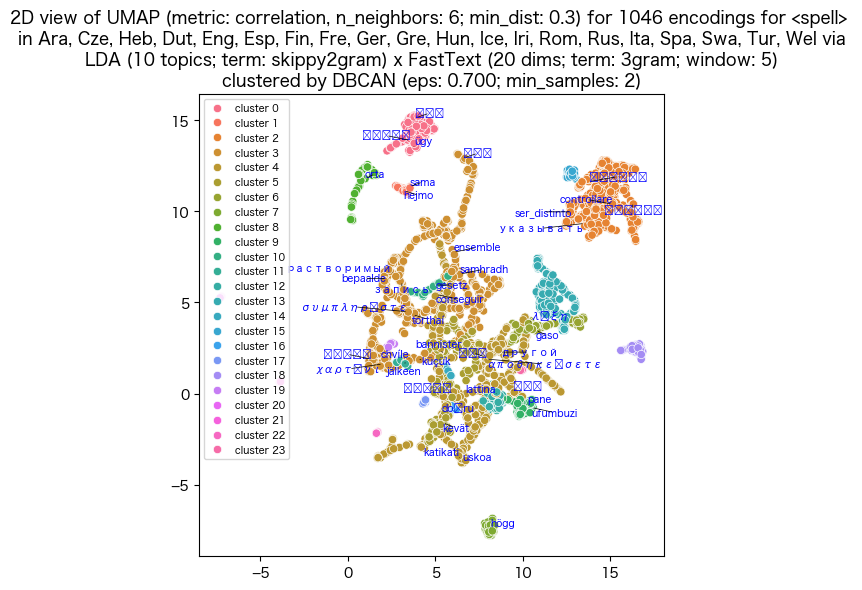

In [2356]:
%%capture --no-display

import seaborn as sns
import matplotlib.pyplot as plt

## 日本語表示のための設定
#plt.rcParams["font.family"] = "Hiragino sans" # Windows/Linux の場合は別のフォントを指定

## 凡例の文字の大きさを指定
param_vals = {'legend.fontsize': 7, 'legend.handlelength': 2}
plt.rcParams.update(param_vals)

## 描画
fig = plt.figure(figsize = (6, 6))
#
d1, d2 = dbscan_source[:,0], dbscan_source[:,1]
sns.scatterplot(x = d1, y = d2, hue = [ f"cluster {l}" for l in dbscan_clustered.labels_ ]) # requires Searborn

## 文字を表示する事例のサンプリング
relative = True
if relative:
    lab_sampling_rate = 0.04 # サンプリング率の指定
    lab_sample_n = round(lab_sampling_rate * len(df))
else:
    lab_sample_n = 30 # 絶対数の指定

## 事例名の生成
texts = [ ]
sampled_keys = [ x[:max_doc_size] for x in random.sample(list(doc_fit_df[doc_type]), lab_sample_n) ]
for x, y, s in zip(d1, d2, sampled_keys):
    texts.append(plt.text(x, y, s, size = 7, color = 'blue'))

## label に repel を追加: adjustText package の導入が必要
adjust_text(texts,
        #force_points = 0.2,
        ## Comment out the following line if you get AttributionError
        force_text = (.1, .2), expand_points = (1, 1), expand_text = (1, 1),
        arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    
## 題名を指定
## used_domains
used_lang_list = f"{', '.join([ l.title() for l in [ l[:3] for l in selected_langs] ])}"
## title_header
df_size = len(df)
if DBSCAN_uses_UMAP:
    title_header = f"2D view of UMAP (metric: {umap_metric}, n_neighbors: {umap_n_neighbors}; min_dist: {umap_min_dist}) for {df_size} encodings for <{doc_attr}> \nin {used_lang_list} via\n"
else:
    title_header = f"2D view of t-SNE (ppl: {doc_perplexity_val}) for {df_size} encodings for <{doc_attr}> in\n{used_lang_list} via\n"
## title_val
if use_FastText:
    if use_LDA:
        title_body = f"LDA ({n_topics} topics; term: {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_boday = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
else:
    title_val = f"LDA ({n_topics} topics; term: {lda_term_type})"
## clustering_method
clustering_method = f"\nclustered by DBCAN (eps: {eps_val:0.3f}; min_samples: {min_samples_val})"
#
title_val = title_header + title_body + clustering_method
plt.title(title_val)
plt.show()
## 局在の程度は character 1-gram, (skippy) 2-gram, (skippy) 3-gram のどれを使うかで違って来る．

In [2361]:
## co-clusteredness に基づく言語間類似度の計算

import pandas as pd
from sklearn.cluster import DBSCAN

#DBSCAN_uses_UMAP = True # tSNE は有効でないようだ
if DBSCAN_uses_UMAP:
    dbscan_source = doc_UMAP_3d
else:
    dbscan_source = doc_tSNE_3d

## eps, min_samples は事例ごとに調節が必要
min_samples_val = 2

## 精度を上げるために，クラスター数を多目にする
scaling_factor = 3
max_n_clusters_for_correl = round(len(selected_langs) * scaling_factor)
print(f"max_n_clusters_for_correl")

print(f"Looking for the optimal eps val...")
check = False
x_dbscan_clustered = None
x_cluster_ids = None
max_val = 5 # needs to be effectively large
eps_vals = np.arange(max_val, 0.005, -0.05)
for eps_val in eps_vals:
    if check:
        print(f"testing eps = {eps_val:0.4f}")
    x_dbscan_clustered_local = DBSCAN(eps = eps_val, min_samples = min_samples_val).fit(dbscan_source)
    x_cluster_ids_local = x_dbscan_clustered_local.labels_
    if check:
        print(f"result: {np.unique(x_cluster_ids_local)}")
    try:
        assert len(np.unique(x_cluster_ids_local)) <= max_n_clusters_for_correl
        x_dbscan_clustered = x_dbscan_clustered_local
        x_cluster_ids = x_cluster_ids_local
    except AssertionError:
        break
#
print(f"final result: {np.unique(x_cluster_ids)}")

## clusterごとに言語の帰属数を集計 
bindings = zip(doc_fit_df[doc_type], doc_fit_df['language'], x_dbscan_clustered.labels_)
binding_df = pd.DataFrame(bindings, columns = ['form', 'language', 'cluster'])

lang_names = sorted(set(binding_df['language']))
print(f"lang_names: {lang_names}")

cluster_ids = sorted(set(binding_df['cluster']))
print(f"cluster ids: {cluster_ids}")

clusterwise_counts = { lang_name : None for lang_name in lang_names }
for lang_name in lang_names:
    counts = [ ]
    selected = binding_df[ binding_df['language'] == lang_name ]
    for i, cluster_id in enumerate(cluster_ids):
        matched = selected[ selected['cluster'] == cluster_id ]
        n_matches = len(matched)
        if n_matches == 0:
            counts.append(0)
        else:
            counts.append(int(n_matches))
    clusterwise_counts[lang_name] = counts

## クラスターでの生起個数の間の相関を計算
clusterwise_counts_df = pd.DataFrame.from_dict(clusterwise_counts) ## Truly versatile
clusterwise_counts_df

max_n_clusters_for_correl
Looking for the optimal eps val...
final result: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55]
lang_names: ['arabic', 'czech', 'dutch', 'english', 'esperanto', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hungarian', 'icelandic', 'irish', 'italian', 'russian', 'spanish', 'swahili', 'turkish', 'welsh']
cluster ids: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]


,arabic,czech,dutch,english,esperanto,finnish,french,german,greek,hebrew,hungarian,icelandic,irish,italian,russian,spanish,swahili,turkish,welsh
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0,15,14,6,23,37,11,5,0,0,15,20,13,18,0,11,19,28,8
2,0,1,1,1,0,3,0,2,0,0,1,7,0,0,0,0,4,1,0
3,119,0,0,0,0,0,0,0,2,170,0,0,0,0,180,0,0,0,1
4,1,21,10,11,25,36,16,7,0,0,16,23,15,31,0,24,10,29,7
5,2,9,12,4,6,13,6,11,0,0,29,3,2,5,1,5,7,20,8
6,0,10,19,9,9,9,11,30,0,0,10,9,11,6,0,6,14,13,3
7,0,36,11,20,22,18,18,7,0,0,17,7,12,19,0,19,5,24,5
8,0,9,0,7,4,5,1,4,0,0,1,11,16,2,0,6,6,2,3
9,0,5,18,12,10,1,21,8,0,0,6,4,7,23,0,20,5,7,8


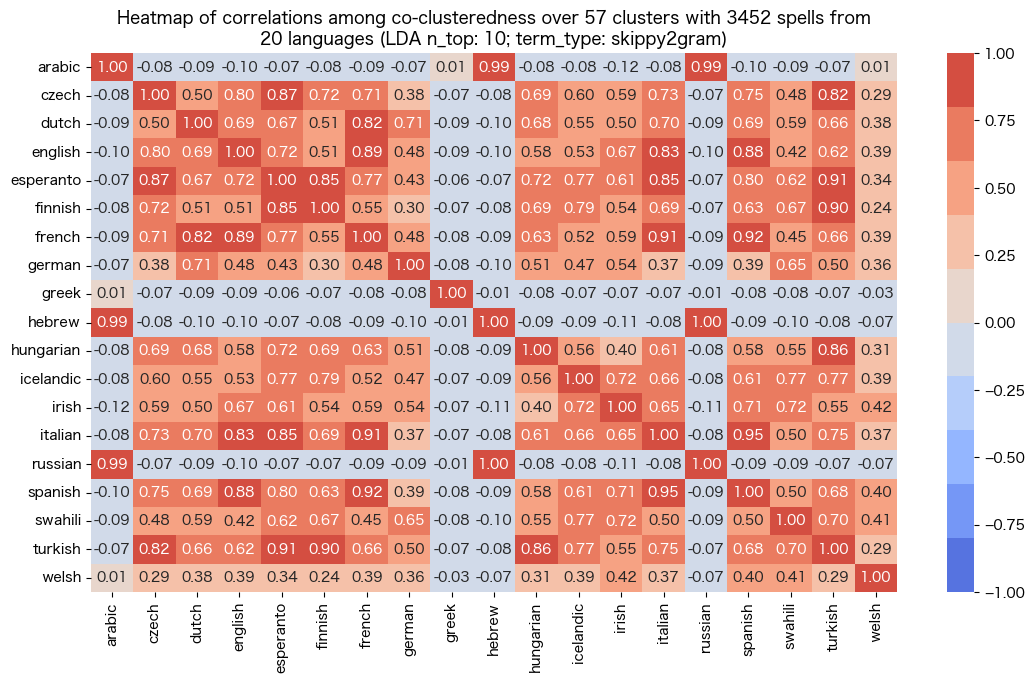

In [2375]:
## Heatmap で可視化

import seaborn as sns

n_langs = len(selected_langs)
fig = plt.figure(figsize = (round(n_langs * 0.65), 7))

corr_df = clusterwise_counts_df.corr()
#corr_df.sort_index(axis = 0, inplace = True)
#corr_df.sort_index(axis = 1, inplace = True)
sns.heatmap(corr_df, cmap = sns.color_palette('coolwarm', 10),
            annot = True, fmt = '.2f', vmin = -1, vmax = 1)

title_val = f"Heatmap of correlations among co-clusteredness over {len(cluster_ids)} clusters with {len(dbscan_source)} {doc_attr}s from\n{n_langs} languages (LDA n_top: {n_topics}; term_type: {lda_term_type})"
plt.title(title_val)
plt.show()

階層クラスタリングのための部分サンプリングの追加

In [2359]:
## 階層クラスタリングのための事例のサンプリング

df_size = len(doc_fit_df)
hc_sampling_rate = 0.1 # 大きくし過ぎると図が見にくい
hc_sample_n = round(df_size * hc_sampling_rate)
doc_hc_df = doc_fit_df.sample(hc_sample_n)
##
print(f"{hc_sample_n} rows are sampled")
doc_hc_df[colored_var].value_counts(sort = True).sort_index()

345 rows are sampled


language
arabic       18
czech        22
dutch        18
english      13
esperanto    13
finnish      22
french       19
german       12
greek        25
hebrew       16
hungarian    15
icelandic    20
irish        24
italian      16
russian      24
spanish      24
swahili      12
turkish      12
welsh        20
Name: count, dtype: int64

階層クラスタリングの実行

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 1505 (\N{HEBREW LETTER SAMEKH}) missing from current font.

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Matplotlib currently does not support Hebrew natively.

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 1504 (\N{HEBREW LETTER NUN}) missing from current font.

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 1496 (\N{HEBREW LETTER TET}) missing from current font.

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 1492 (\N{HEBREW LETTER HE}) missing from current font.

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 1497 (\N{HEBREW LETTER YOD}) missing from current font.

/Volumes/K/opt/minico

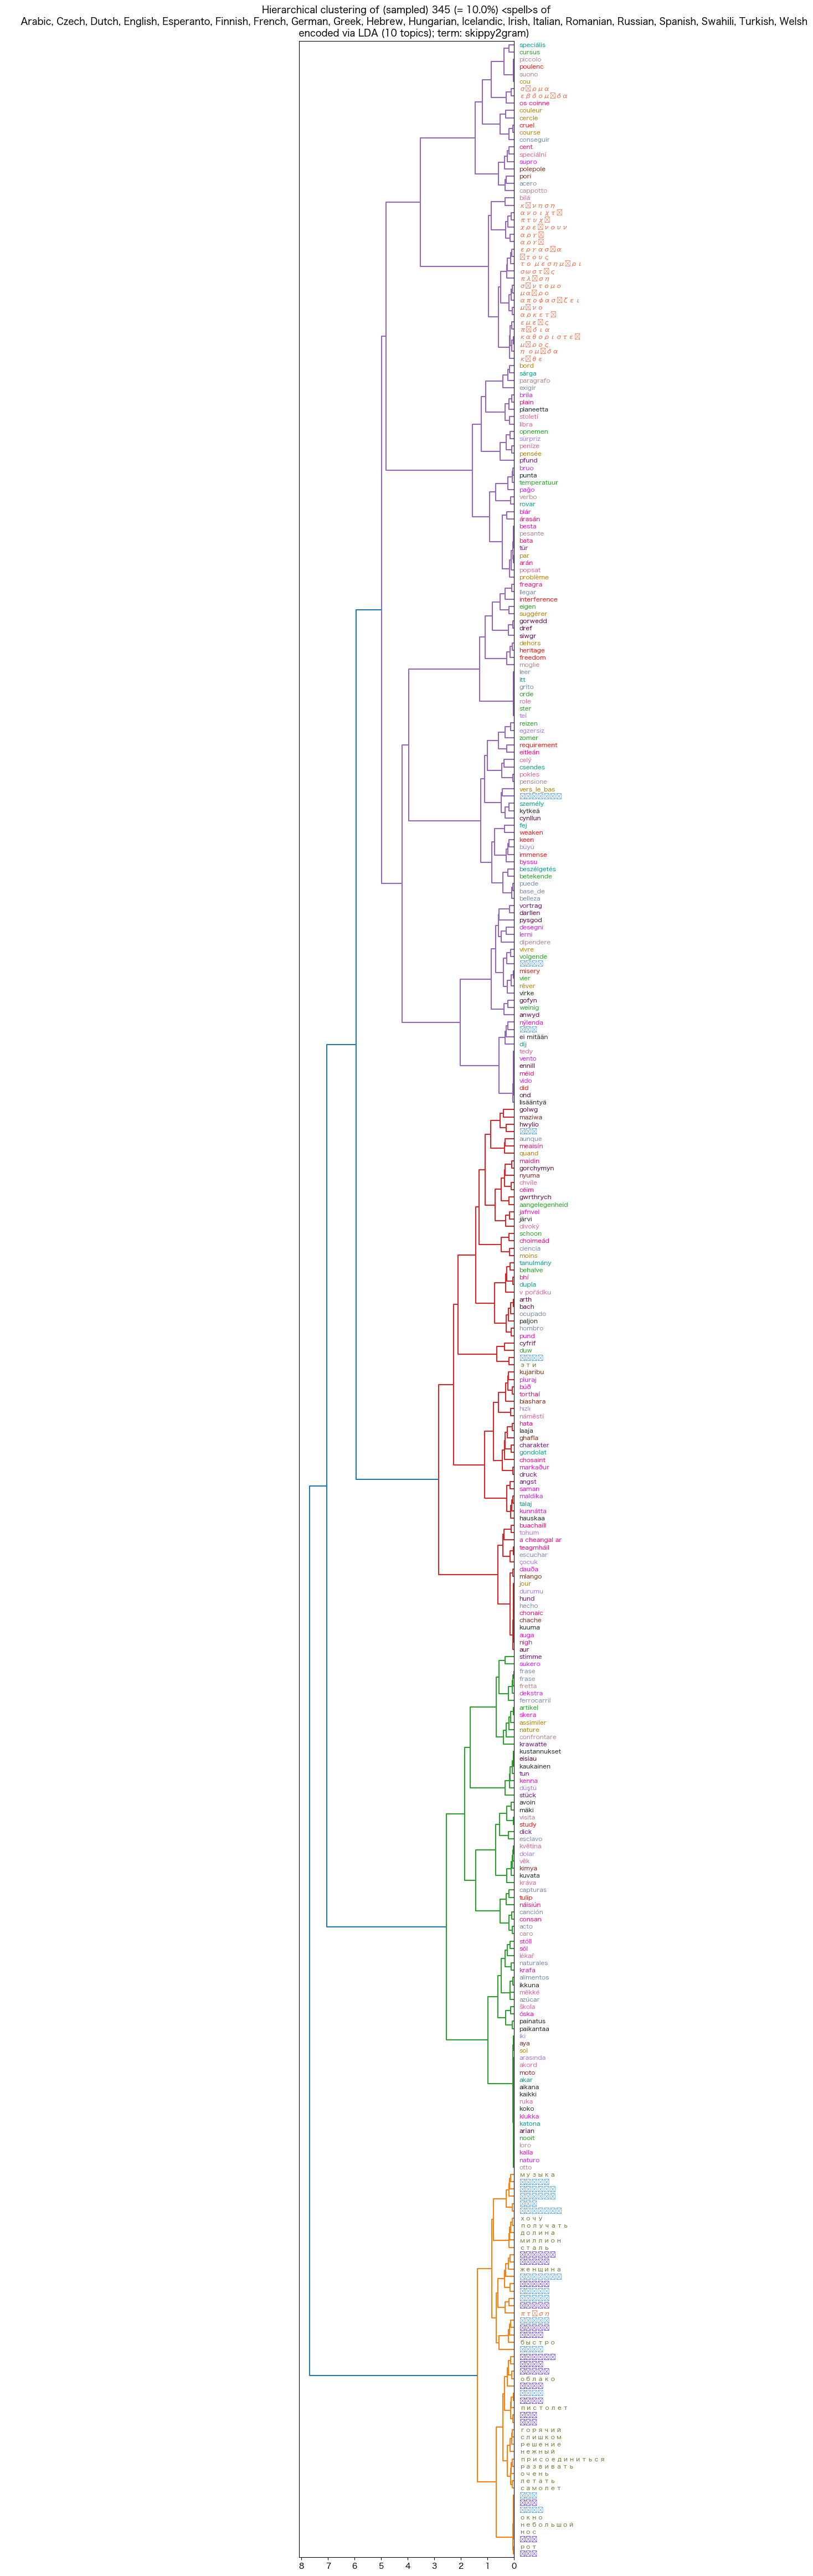

In [2360]:
## doc 階層クラスタリングの実行

import numpy as np
import plotly
import matplotlib.pyplot as plt
## 次の設定は arabic, bengali が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある

## 描画サイズの指定
plt.figure(figsize = (5, round(len(doc_hc_df) * 0.17))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_vals = [ x[:max_doc_size] for x in list(doc_hc_df[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
from scipy.cluster.hierarchy import dendrogram, linkage

## 距離行列の生成
doc_hc_enc = list(doc_hc_df['enc'])
doc_linkage = linkage(doc_hc_enc, method = 'ward', metric = 'euclidean')
dendrogram(doc_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)

## 描画
plt.title(f"Hierarchical clustering of (sampled) {len(doc_hc_df)} (= {100 * hc_sampling_rate}%) <{doc_attr}>s of\n \
    {', '.join([ l.title() for l in sorted(selected_langs)])}\n \
    encoded via LDA ({n_topics} topics); term: {lda_term_type})")

## ラベルに language に対応する色を付ける
lang_colors = { lang_name : i for i, lang_name in enumerate(np.unique(doc_hc_df[colored_var])) }
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    form = ticker.get_text()
    row = doc_hc_df.loc[doc_hc_df[doc_type] == form]
    lang = row[colored_var].to_string().split()[-1] # trick
    try:
        lang_id = lang_colors[lang]
    except (TypeError, KeyError):
        print(f"color encoding error at: {lang}")
    #
    ticker.set_color(color_palette[lang_id])
#
plt.show()
## A few Turkish words will be partially garbled.